In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Reading the files from stored npy file**

In [ ]:

import numpy as np
x_train = np.load('/content/drive/My Drive/pgmend/x_train.npy')
y_train = np.load('/content/drive/My Drive/pgmend/y_train.npy')
x_val = np.load('/content/drive/My Drive/pgmend/x_val.npy')
y_val = np.load('/content/drive/My Drive/pgmend/y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)



(582, 256, 256, 1) (582, 256, 256, 1)
(65, 256, 256, 1) (65, 256, 256, 1)


In [ ]:


import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.


# Network Architecture

**This network is an autoencoder which segements the organs in the original image and gives us the segmented output. This network is trained with mri images and their corresponding ground truth values** (Further changes to be done in future)

In [ ]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0   

In [ ]:


history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])



Train on 582 samples, validate on 65 samples
Epoch 1/100
582/582 [==============================] - 331s 568ms/step - loss: 0.1465 - acc: 0.9067 - mse: 0.0251 - val_loss: 0.1217 - val_acc: 0.9460 - val_mse: 0.0104
Epoch 2/100
582/582 [==============================] - 321s 552ms/step - loss: 0.0974 - acc: 0.9552 - mse: 0.0097 - val_loss: 0.0957 - val_acc: 0.9460 - val_mse: 0.0101
Epoch 3/100
582/582 [==============================] - 317s 544ms/step - loss: 0.0797 - acc: 0.9552 - mse: 0.0093 - val_loss: 0.0800 - val_acc: 0.9460 - val_mse: 0.0095
Epoch 4/100
582/582 [==============================] - 319s 548ms/step - loss: 0.0689 - acc: 0.9552 - mse: 0.0088 - val_loss: 0.0716 - val_acc: 0.9460 - val_mse: 0.0088
Epoch 5/100
582/582 [==============================] - 315s 542ms/step - loss: 0.0639 - acc: 0.9552 - mse: 0.0084 - val_loss: 0.0677 - val_acc: 0.9460 - val_mse: 0.0085
Epoch 6/100
582/582 [==============================] - 317s 545ms/step - loss: 0.0618 - acc: 0.9552 - mse: 0.0

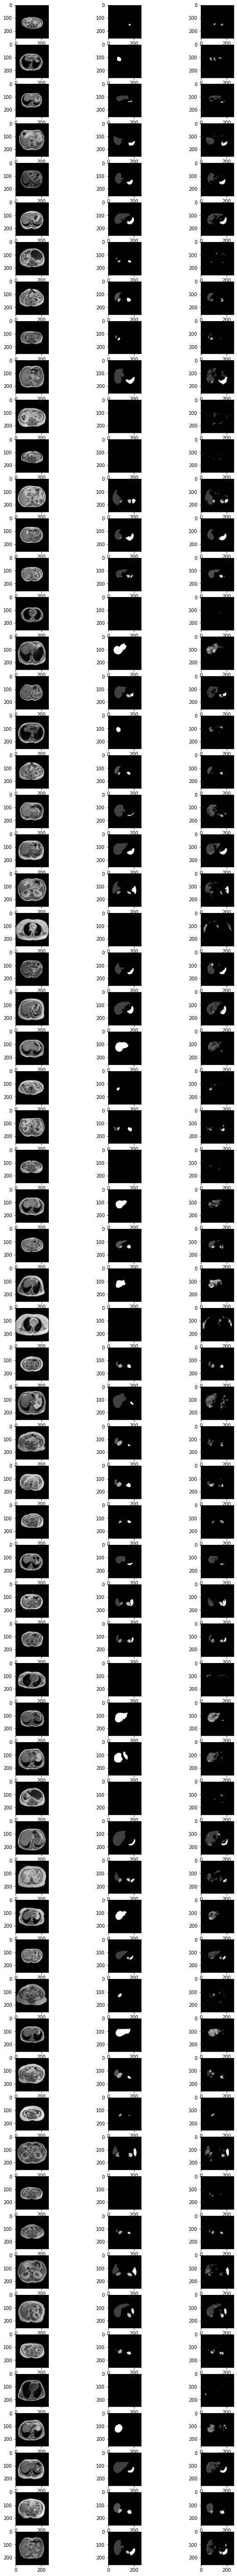

In [ ]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

In [ ]:
model.save('/content/drive/My Drive/pgmend/pgm_model.h5')

In [ ]:
model.get_weights()

[array([[[[ 0.10280839,  0.0964639 ,  0.02109338, -0.09812395,
           -0.10847105, -0.09038531,  0.09647407, -0.03839217,
           -0.08130382, -0.0869729 ,  0.11694223, -0.15355054,
            0.1380348 ,  0.1662049 ,  0.14685734, -0.16589624,
            0.10782733,  0.02265627, -0.10458159, -0.00773581,
           -0.07721835, -0.17408739, -0.04652312, -0.17521572,
            0.10384835, -0.12328228, -0.18002363, -0.07859854,
           -0.1472747 , -0.02099812,  0.09341023, -0.06792124]],
 
         [[-0.06632918, -0.16794766,  0.00791923,  0.10186557,
           -0.07568947,  0.11209043, -0.12414916,  0.06104665,
            0.01226616,  0.02262511, -0.03905401,  0.07144637,
            0.03103161,  0.05219043, -0.0701694 ,  0.11178337,
           -0.03674782,  0.11338348, -0.05369517, -0.05446168,
            0.06000312,  0.01220262, -0.07698672, -0.05957437,
            0.09734895,  0.05088085, -0.05661705,  0.13343354,
            0.03593829,  0.11026589, -0.10750452,  